In [4]:
import sys  
sys.path.insert(0, '../search-engine')
from utils import *
from sklearn.manifold import TSNE
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from collections import Counter

# NB1: Output Analysis

## Top-20 lists of ranked documents
The Top-20 lists for *tf-idf* and *Word2Vec* are stored in TSV files with the name of the query. Example: `RQ1_tf-idf_Trump.tsv`

In [5]:
# Import data and select a smaller sample 
data = get_tweets(None, None, mode = "read", data_directory = '../data/')
sample = 10000
data = data[:sample]

In [4]:
# Create dictionary of tweets and inverted index
tweetsDict = create_tweets_dict(data)
index, tf, df, idf = create_index_tfidf(data, len(data))

In [72]:
# Create the scores for the queries and
topk = 20
queries = ["Trump", "US election", "election", "georgia voting", "vote trump",
          "vote biden", "trump biden", "vote fraud", "republican party", "democratic party"]

for query in queries:
    # Compute scores
    scores = personalized_rank(query, index, tf, idf, tweetsDict, data)
    
    # Sort by tf-idf and by Word2Vec
    result_tfidf = scores.sort_values(by="tf-idf", ascending = False)[:topk]
    texts_tfidf = [tweetsDict[i] for i in list(result_tfidf.index)]
    
    result_w2v = scores.sort_values(by="w2v", ascending = False)[:topk]
    texts_w2v = [tweetsDict[i] for i in list(result_w2v.index)]
    
    # Create dataframe structure
    d = {"tf-idf tweet idx": list(result_tfidf["tf-idf"].index), "tf-idf score": result_tfidf["tf-idf"], 
         "tf-idf texts": texts_tfidf, "w2v tweet idx": list(result_w2v["w2v"].index), 
         "w2v score": list(result_w2v["w2v"]), "w2v texts": texts_w2v}
    
    # Output dataframe to TSV files
    df = pd.DataFrame.from_dict(d).reset_index().drop(columns=["index"])
    df.to_csv("../other-outputs/RQ1_" + query + ".tsv", sep="\t", index=False)

## TSNE

In [6]:
# Create tweets dict
tweets_df = pd.DataFrame.from_dict(create_tweets_dict(data), orient='index', columns = ["Text"])

In [7]:
# Compute tweets embeddings using word2vector

# Collect tweets' terms to create w2v_model
words = []
for tweet in data:
    try: text = tweet["full_text"]
    except: text = tweet["text"]
    words.append(normalize_text(text))
    
# Store normalized text in tweets dict    
tweets_df["Normalized_Text"] = words
tweets_df["Normalized_Text"] = tweets_df["Normalized_Text"].apply(lambda x: ' '.join(x))
    
# Initialize word2vec model    
w2v_model = Word2Vec(sentences = words, size = 20, window = 10, min_count = 0, negative = 10, sg = 0)

# Compute tweets' vector embedding 
vectors = np.zeros((len(data), w2v_model.vector_size))
for i, tweet in enumerate(data):
    try: text = tweet["full_text"]
    except: text = tweet["text"]
    vectors[i,:] = mean_w2v(text, w2v_model, tweet=False)

In [12]:
X = vectors

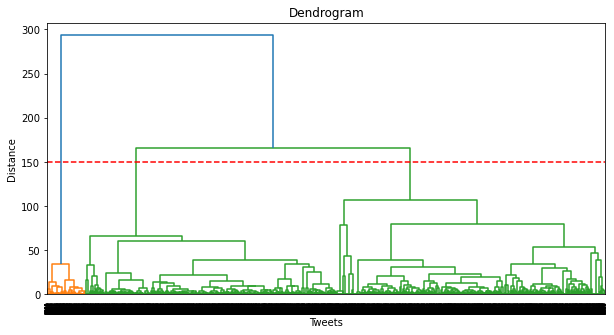

In [5]:
# Compute dendrogram to estimate the number of clusters
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.axhline(y=150, color='r', linestyle='--')
plt.title("Dendrogram")
plt.ylabel("Distance")
plt.xlabel("Tweets")
plt.show()

In [9]:
# Clustering 
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters, linkage='ward').fit(X)

assert(len(set(clustering.labels_)) == n_clusters)
tweets_df["Cluster"] = clustering.labels_

In [11]:
# Initialize TSNE model 
tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=32)

# Transform w2v embeddings into 2d arrays 
embeddings_2d = np.array(tsne_model_en_2d.fit_transform(X))

In [13]:
# Prepare data for plot
clusters = {}
for vector, label, dict_key in zip(embeddings_2d, clustering.labels_, tweetsDict):
    try: clusters[label] = np.vstack((clusters[label], vector))
    except: clusters[label] = vector

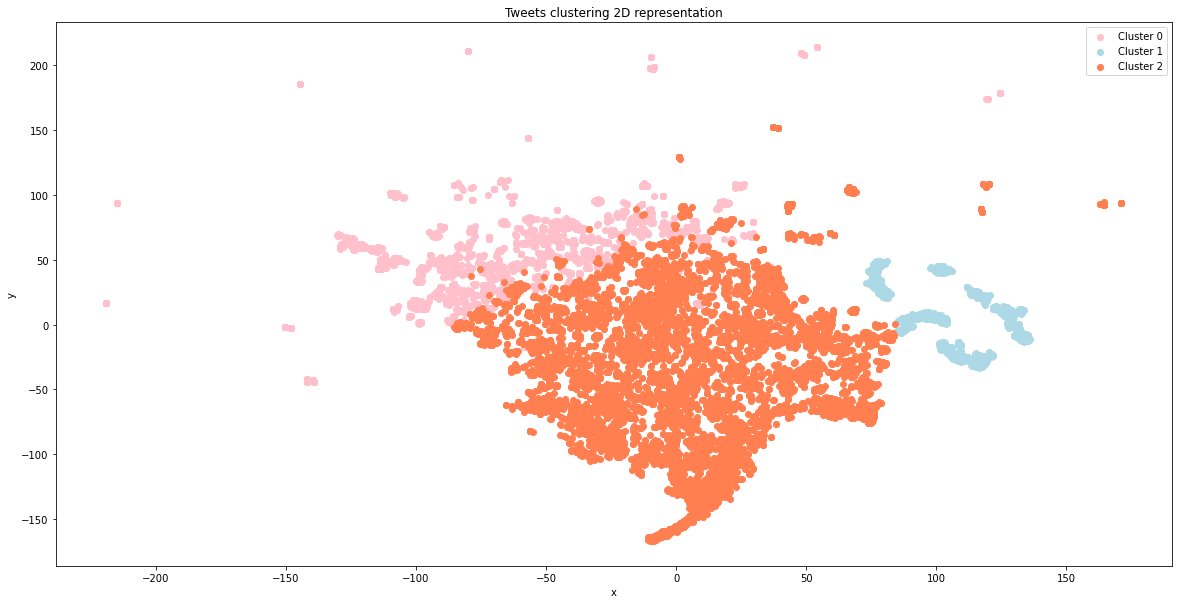

In [14]:
# Plot clusters into 2D 
plt.figure(figsize=(20,10))
color = ["pink", "lightblue", "coral"]

for i in range(n_clusters):
    plt.scatter(clusters[i][:, 0], clusters[i][:, 1], color = color[i], label="Cluster {}".format(i))
    # FICAR LABELS I AXIS (X, Y) I COLORS MONOS
plt.title("Tweets clustering 2D representation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Clustering interpretation

In [22]:
# Print random tweets from each cluster in order to understand its topic
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

for i in range(n_clusters):
    print("\033[1m \nFive random tweets from cluster {} \033[0m".format(i))
    for j, text in enumerate(tweets_df[tweets_df["Cluster"] == i]["Text"].sample(5).values):
        print("\033[32m {} tweet: {} \033[0m".format(ordinal(j + 1), text))
        


Five random tweets from cluster 0
1st tweet: RT @donwinslow: Dear @realDonaldTrump 

Actually, you just lost. 

By a landslide in the electoral college.

And by 7 million votes in the…
2nd tweet: RT @ColumbiaBugle: One Of The Most Powerful Moments In @realDonaldTrump Rally History 

“FIGHT FOR TRUMP! FIGHT FOR TRUMP!” https://t.co/Qn…
3rd tweet: RT @dbongino: It’s Sunday, December 6th 2020, and the Obama/Biden administration was the most corrupt in US history.
#Obamagate
4th tweet: @montaga @GOP @realDonaldTrump Trump turned out 80 million people to vote against him.
5th tweet: @GaRepublicans @Perduesenate @realDonaldTrump @KLoeffler Could outgoing impeached Trump come back and do a couple more of those loser rallies?  Asking for the Democrats.

Five random tweets from cluster 1
1st tweet: RT @Chanduqueen44: I vote #SurbhiChandna for Naagin5 

#TVPersonalityWithRajBaddhan 
@RajBaddhan @SabrasRadio @BizAsia
2nd tweet: RT @ittu_love_helly: Gorgeous

I vote #HellyShah for Ishq Mein Marja

In [23]:
# Print five most common words from each cluster

for i in range(n_clusters):
    lst_tweets = tweets_df[tweets_df["Cluster"] == i]["Normalized_Text"]
    lst_words = []
    for tweet in lst_tweets:
        lst_words += tweet.split()
        
    print("\033[1m \nMost common words in cluster {}: \033[0m".format(i))
    for word, value in Counter(lst_words).most_common(5):
        print(word)

 
Most common words in cluster 0: 
trump
realdonaldtrump
election
fight
president
 
Most common words in cluster 1: 
vote
sabrasradio
rajbaddhan
tvpersonalitywithrajbaddhan
bizasia
 
Most common words in cluster 2: 
trump
vote
biden
president
georgia


In [139]:
# Save the clustering into a csv to use the processed data in RQ2
tweets_df[["Text", "Cluster"]].to_csv("../other-outputs/clustering_output_10000.csv")